Using TensorFlow backend.


Found 648 images belonging to 2 classes.
162/162 [==============================] - 354s 2s/step
Found 122 images belonging to 2 classes.
Found 648 images belonging to 2 classes.
Found 122 images belonging to 2 classes.
Train on 648 samples, validate on 122 samples
Epoch 1/40
648/648 [==============================] - 2s 3ms/step - loss: 0.7410 - acc: 0.4861 - val_loss: 0.7010 - val_acc: 0.2377
Epoch 2/40
648/648 [==============================] - 1s 2ms/step - loss: 0.7274 - acc: 0.6188 - val_loss: 0.8130 - val_acc: 0.5082
Epoch 3/40
648/648 [==============================] - 1s 1ms/step - loss: 0.5953 - acc: 0.7438 - val_loss: 0.5127 - val_acc: 0.8361
Epoch 4/40
648/648 [==============================] - 1s 2ms/step - loss: 0.5007 - acc: 0.7438 - val_loss: 0.3968 - val_acc: 0.8443
Epoch 5/40
648/648 [==============================] - 1s 2ms/step - loss: 0.4813 - acc: 0.8102 - val_loss: 0.5166 - val_acc: 0.8852
Epoch 6/40
648/648 [==============================] - 1s 2ms/step - loss: 

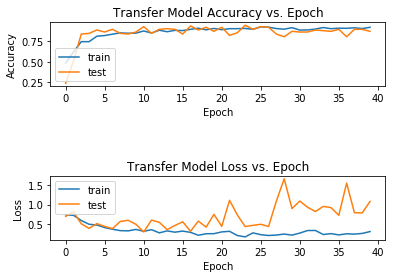

In [ ]:
'''
Steve Winnall 10 Aug 2019
This code is work toward the Udacity Machine Learning NanoDegree Capstone Project
"The Art Thief - Is this a Whiteley?"
Using machine learning to identify a "fake" Brett Whiteley paiting.

Use the VGG16 model and transfer learning to perform binary image classification (logistic regression)
VGG model trained using the ImageNet Library
VGG16: From the paper by Simonyan and Zisserman "Very Deep Convolutional Networks for Large-Scale Image Recognition"
https://arxiv.org/abs/1409.1556
'''

#imports
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import applications
from keras import backend as K
import matplotlib.pyplot as plt
import math
import cv2
%matplotlib inline

#Location of the training and validation images
train_dir = 'data/train'
validation_dir = 'data/validation'

# dimensions of the images.
img_width, img_height = 224, 224
# number of epochs to train top model
epochs = 40
# batch size used by flow_from_directory and predict_generator
batch_size = 4

#location of the bottleneck weights
top_model_weights_path = 'bottleneck_fc_model.h5'

#ensuring the data is in the correct format "channels_first" or "channels_last"
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


def save_bottlebeck_features():
    # build the VGG16 model removing the Top layers to provide for transfer learning.  
    model = applications.VGG16(include_top=False, weights='imagenet',  pooling=None)

    # only image manipulation is scaling (no augmentation)
    scale_gen = ImageDataGenerator(rescale=1. / 255)

    #create the data for training images
    generator = scale_gen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False) #notice no shuffling
    
    
    nb_train_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    #prediction of the bottleneck features and save them(training) 
    bottleneck_training = model.predict_generator(
        generator, predict_size_train, verbose=1)

    np.save('bottleneck_training.npy', bottleneck_training)
    
    #create the data for the scaling images
    generator = scale_gen.flow_from_directory(
        validation_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    #prediction of the bottleneck features and save them (validation) 
    bottleneck_validation = model.predict_generator(
        generator, predict_size_validation)

    np.save('bottleneck_validation.npy',
            bottleneck_validation)


def train_top_model():
    #again create the input data using flow_from_directory and only rescale image 
    scale_gen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = scale_gen_top.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    
    #number of labelled training samples
    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use use later in predictions
    np.save('class_indices.npy', generator_top.class_indices)

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes
    
    # load the previously created bottleneck features
    train_data = np.load('bottleneck_training.npy')

    # convert the training labels to categorical vectors (make use of to_categorical) 
    train_labels = to_categorical(train_labels, num_classes=num_classes)
    
    #again create the input data using flow_from_directory and only rescale image 
    generator_top = scale_gen_top.flow_from_directory(
        validation_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    #load the previously created bottleneck features
    validation_data = np.load('bottleneck_validation.npy')
    
    #number of labelled validation samples
    nb_validation_samples = len(generator_top.filenames)

    validation_labels = generator_top.classes
    
    # convert the validation labels to categorical vectors (make use of to_categorical) 
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)

    #adding the head of the model for retraining on the images
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(16, activation='relu')) 
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='sigmoid')) #binary classification

    #make use of the categorical cross-entropy loss function
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    #training the new model (transfer learning from VGG16 trained on imagenet)
    
    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("--------------")
    print("Model Loss: {:.3f}".format(eval_loss))
    print("Model Accuracy: {:.1f}%".format(eval_accuracy * 100))
    print("--------------")
    
    plt.figure(1)

    # Show the transfer learning progress by epoch

    plt.subplot(311)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Transfer Model Accuracy vs. Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='lower left')

    # Show the loss per epoch

    plt.subplot(313)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Transfer Model Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def predict():
    #this function is to predict the fake painting
    #If it classifies as a Whiteley it is unable to distinguish the difference between a real and fake Whiteley
    
    # load the indices
    class_dictionary = np.load('class_indices.npy').item()

    #determing number of classes (2)
    num_classes = len(class_dictionary)

    # add the path to your test image below
    image_path = 'data/eval/fake_whiteley.jpg'
    
    #use cv2 to load the image
    fake_image = cv2.imread(image_path)

    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    #  image scaling
    image = image / 255
    image = np.expand_dims(image, axis=0)

    # create the VGG16 model with the Top Layers removed (transfer learning)
    model = applications.VGG16(include_top=False, weights='imagenet')

    # add the bottleneck features we have created after training on the 
    bottleneck_predict = model.predict(image)

    # rebuild the head using the model
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_predict.shape[1:]))
    model.add(Dense(16, activation='relu'))  
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='sigmoid')) #binary image classification

    model.load_weights(top_model_weights_path)

    # classify using the bottleneck features
    class_predicted = model.predict_classes(bottleneck_predict)

    probabilities = model.predict_proba(bottleneck_predict)

    inID = class_predicted[0]

    inv_map = {v: k for k, v in class_dictionary.items()}

    label = inv_map[inID]

    #Is it a fake?
    position = (10,50) #writing start position
    cv2.putText(
         fake_image, 
         "It is a: {}".format(label),  
         position, 
         cv2.FONT_HERSHEY_DUPLEX,  
         1, #font size
         (209, 80, 0, 255), #font color
         3) #font stroke
    
    
    cv2.imshow("Classification", fake_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# execute the functions
save_bottlebeck_features()
train_top_model()
predict()
